<a href="https://colab.research.google.com/github/DevanshPatel234/Innovators_Object_Detection_using_faster-R-CNN/blob/main/Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()
])
mnist_data = torchvision.datasets.MNIST(root='./content/coco', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 89.4MB/s]


Extracting ./content/coco/MNIST/raw/train-images-idx3-ubyte.gz to ./content/coco/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 11.5MB/s]

Extracting ./content/coco/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/coco/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 43.4MB/s]


Extracting ./content/coco/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/coco/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.88MB/s]

Extracting ./content/coco/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/coco/MNIST/raw



In [5]:
num_images = 100
num_per_row = 4

coco_images = [mnist_data[i][0] for i in range(num_images)]
coco_labels = [mnist_data[i][1] for i in range(num_images)]

In [6]:
image, label, bounding_boxes = [], [], []
image_size = 256  # Adjusted image size

for i in range(num_images):
    indices = random.sample(range(len(coco_images)), num_per_row)
    row = torch.cat([coco_images[idx] for idx in indices], dim=2)
    image.append(row)
    label.append([coco_labels[idx] for idx in indices])

    # Define bounding boxes for each image in the row
    row_bboxes = []
    for col_idx in range(num_per_row):
        x_min = col_idx * image_size
        y_min = 0
        x_max = x_min + image_size
        y_max = y_min + image_size
        row_bboxes.append([x_min, y_min, x_max, y_max])
    bounding_boxes.append(row_bboxes)

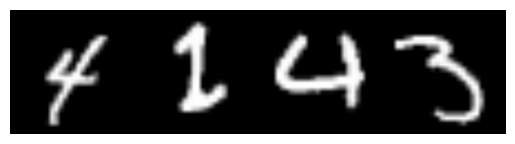

In [7]:
stacked_pil = transforms.ToPILImage()(image[0])
plt.imshow(stacked_pil)
plt.axis('off')
plt.show()

In [8]:
class mnist_Data(Dataset):
    def __init__(self, image, label, bounding_boxes, device):
        self.image = image
        self.label = label
        self.bounding_boxes = bounding_boxes
        self.device = device

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        target = {
            "boxes": torch.as_tensor(self.bounding_boxes[idx], dtype=torch.float32),
            "labels": torch.as_tensor(self.label[idx], dtype=torch.int64)
        }
        img = img.to(self.device)
        target = {k: v.to(self.device) for k, v in target.items()}
        return img, target

In [9]:
data = mnist_Data(image, label, bounding_boxes, device)
dataloader = DataLoader(data, batch_size=1, shuffle=True)

In [10]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)  # Move model to GPU if available
model.train()  # Set the model to training mode

# Define optimizer and training parameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5  # Train for 5 epochs initially
all_losses = []  # List to track losses

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 151MB/s]


In [11]:
# Training Loop with Metric Calculation
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    pred_labels = []

    for images, targets in dataloader:  # Iterate using dataloader
        images, targets = data[i]
        images = images.unsqueeze(0)  # Add batch dimension
        targets = [targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

        # Extract predictions for metric calculation (within the loop)
        with torch.no_grad():
            model.eval()
            predictions = model(images)
            model.train()
            for i, prediction in enumerate(predictions):
                # Assuming only one object per image for simplicity
                pred_labels.append(prediction["labels"][0].cpu().item()) # Get the first prediction
                true_labels.append(targets[i]["labels"][0].cpu().item())


    # Calculate metrics for the epoch
    precision = precision_score(true_labels, pred_labels, average='micro')
    recall = recall_score(true_labels, pred_labels, average='micro')
    accuracy = accuracy_score(true_labels, pred_labels)

    # Log losses and metrics
    all_losses.append(epoch_loss)  # Appending the epoch loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/5], Total Loss: 21.5047, Precision: 0.8900, Recall: 0.8900, Accuracy: 0.8900
Epoch [2/5], Total Loss: 3.2696, Precision: 0.7800, Recall: 0.7800, Accuracy: 0.7800
Epoch [3/5], Total Loss: 2.1535, Precision: 0.0000, Recall: 0.0000, Accuracy: 0.0000
Epoch [4/5], Total Loss: 2.0100, Precision: 0.7000, Recall: 0.7000, Accuracy: 0.7000
Epoch [5/5], Total Loss: 1.6719, Precision: 1.0000, Recall: 1.0000, Accuracy: 1.0000


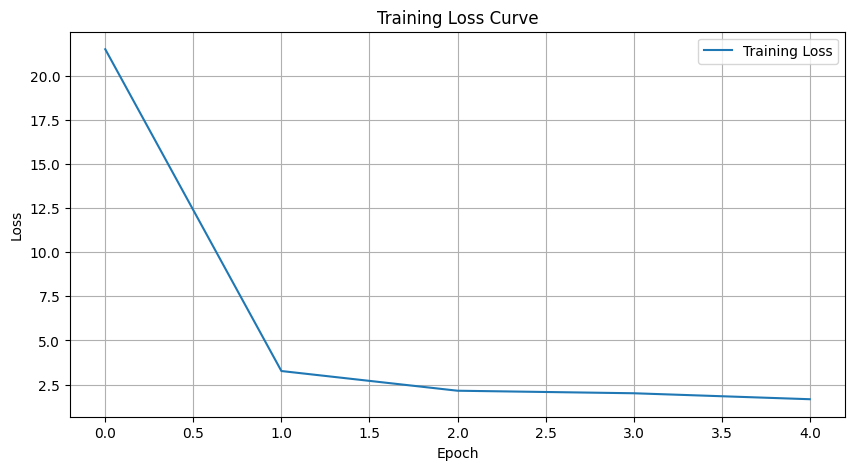

In [12]:
# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Function to visualize predictions
def plot_prediction(model, image, target):
    image = image.to(device)

    # Perform inference
    model.eval()
    with torch.no_grad():
        prediction = model([image])

    # Convert image tensor to PIL image for display
    image_pil = transforms.ToPILImage()(image.cpu())

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)

    # Display the ground truth bounding boxes
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)

    # Display the predicted bounding boxes
    top_4_indices = torch.argsort(prediction[0]['scores'], descending=True)[:4]
    for index in top_4_indices:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][index].tolist()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(xmin, ymin, f"Label:{prediction[0]['labels'][index].item()}, Score:{prediction[0]['scores'][index].item():.2f}", color='r')

    plt.axis('off')
    plt.show()

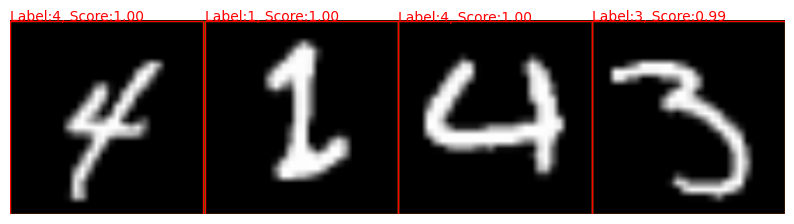

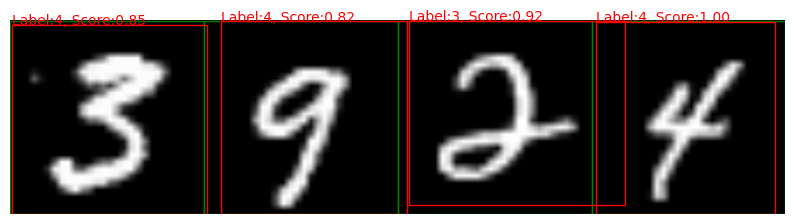

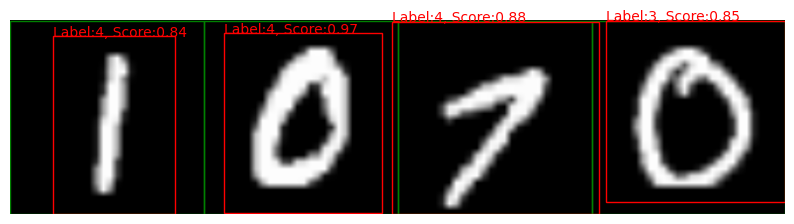

In [14]:
# Test the model on the test dataset
for i in range(3):  # Display predictions for 3 samplesn\
    img, tgt = data[i]
    plot_prediction(model, img, tgt)